# Data analysis @ Atlas

Description
----------------------------------------
This data is a very small subset of our customers (16 instances) for JIRA family of products. It covers ~1 month and represents ~500 end users.
All strings and some numeric values are hashed for privacy reasons. However, the same hashing method is used for each string, so it is possible to link for example 'issueKey' across different events.

Fields
----------------------------------------
time_string : Date and time in readable format
unix_time   : Timestamp (in milliseconds)
instance    : The name of the customer
product     : Always equal to 'jira'
username    : A user ID
event       : The action that user made. Typically one event per user-click, but that's not always the case since sometimes one action may trigger more than one events.
attributes  : Extra information about the event in JSON-like format

Example of dataset row
----------------------------------------
2014-12-01 16:00:02,153	1417410002153	3998740a9e4924af7feedeb2e04190f6	jira	d50d63ec8ecdf32d1dd9ae4a0cecd2f8	quickbrowse	{'issueKey': 'eaf34eb91618cf3e1bf487a822a2cce6'}

===

# Report @ Data

## Key Findings

** EDA **

- There is a trend of losing traction in this month period due to Holiday season , e.g. Chrismas Eve
- There are some peaks at 4 AM of 4th, 5 AM of 6th and 6 AM of 17th. On 21st, 25th holidays take place and keep continuing by year end season.
- More event traffic on Tue and go forth, less at weekend as normally

- event 402 - viewIssue appear to very active along the days, it has strong correlation with event 103 - browserWindowSize and 383 criteriaAutoUpdateEnabled. Event 98 - metrics.navigation takes seconds place of all traffic

- instance 12 is champion for all the metrics: num of users, events and total transactions

** Cluster analysis **

- Events and Users are quite related and having strong cosine simalarity 
- We can dive into further in TSNE part

** Cohort analysis **

- Interesting cohort is 2014-12-01 for group of active users. They are very loyal and having more actions than other groups. What makes this cohort different?
- No new cohort on 21,25,27, 28 when holiday season took place

===

# Workflow

## Prelim/ Processing

In this phase, the focus is to make the data usable as quickly as possible and get quick and interesting insights.

Dataset is quite clean with some details:

- Dataset: 592458 rows x 7 cols
- No missing data: quite good
- Instance, User, Events distributions: Exp., e.g. long tail
- Data kind of timeseries

My work consists of 3 parts including my inline comments

## Part 1: EDA

I gonna do several taks:

- distribution visuallization
- time analysis
- trend estimation
- event based heatmap
- day period based
- instance - user - event correlation

## Part 2: Cluster Analysis

Based on occurrences of events and users, we are able to have insights how similar they are, can we group them to utitlise for other applications like recommendations, outliers/novelty detection


## Part 3: Cohort Analysis

User retention is critical for any kind of business. We'll see how different cohort groups behave in 

## Future work

Due to time limit, I'd pay more attention on following problems:

- When is the next event triggered? Inter-event time regression to predict in how many seconds user will create one?
- Fraud/Outliers/Novelty detection on realtime events
- Diving into extra fields


In [1]:
%bookmark atl /home/laampt/github/laamp/atlas

In [2]:
cd atl

(bookmark:atl) -> /home/laampt/github/laamp/atlas
/home/laampt/github/laamp/atlas


In [ ]:
!head -n 5 jira_clean.tsv

In [3]:
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight') # Good looking plots

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', None) # Display any number of columns
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns

%matplotlib inline

In [5]:
columns = ['ts', 'u_ts', 'instance', 'product', 'user_name', 'event', 'extra']
df = pd.read_csv("data/jira_clean.tsv", sep='\t', names=columns)

In [6]:
df.head()

,ts,u_ts,instance,product,user_name,event,extra
0,"2014-12-01 16:00:02,153",1417410002153,3998740a9e4924af7feedeb2e04190f6,jira,d50d63ec8ecdf32d1dd9ae4a0cecd2f8,quickbrowse,{'issueKey': 'eaf34eb91618cf3e1bf487a822a2cce6'}
1,"2014-12-01 16:00:07,691",1417410007691,3998740a9e4924af7feedeb2e04190f6,jira,d50d63ec8ecdf32d1dd9ae4a0cecd2f8,kickass.criteriaAutoUpdateEnabled,{'context_pageTime': '6ce628243b670aff9f549029...
2,"2014-12-01 16:00:07,691",1417410007691,3998740a9e4924af7feedeb2e04190f6,jira,d50d63ec8ecdf32d1dd9ae4a0cecd2f8,kickass.viewIssue,{'context_pageSession': 'a09b1242b4712e1cb23bf...
3,"2014-12-01 16:00:07,691",1417410007691,3998740a9e4924af7feedeb2e04190f6,jira,d50d63ec8ecdf32d1dd9ae4a0cecd2f8,browserWindowSize,"{'width': '00409424d52c3a1a30e98cd1cd91638a', ..."
4,"2014-12-01 16:00:10,523",1417410010523,c93da7e17688ef90fc43963b5a6c6259,jira,2cc91ff23ca6213e8a7d2513a31d8fa8,lexorankbalance,{'fieldId': '4537ecbd3f85c18825157673510a445d'...


In [7]:
df.tail()

,ts,u_ts,instance,product,user_name,event,extra
592453,"2014-12-31 23:45:34,823",1420029934823,3998740a9e4924af7feedeb2e04190f6,jira,637d4577b31590a8543c8b75744ac5cb,webhooks.published,{'webHookId': '1d874d6c799b40a5b0883ed4280ce2c9'}
592454,"2014-12-31 23:45:34,825",1420029934825,3998740a9e4924af7feedeb2e04190f6,jira,637d4577b31590a8543c8b75744ac5cb,issuecommented,{'sendMail': '1b4364fe924a8edf298fa9fa0e36c76d...
592455,"2014-12-31 23:50:56,352",1420030256352,c93da7e17688ef90fc43963b5a6c6259,jira,5058c6eaa55616594dd10e71a4e88f02,jira.dashboard.gadgets.twodstats.rowscount,{'value': 'ba285024d0a55bf6b97fd930c25455a8'}
592456,"2014-12-31 23:50:56,353",1420030256353,c93da7e17688ef90fc43963b5a6c6259,jira,5058c6eaa55616594dd10e71a4e88f02,jira.dashboard.gadgets.twodstats.colscount,{'value': '7f76b990f68b7b6a80452ed978fcc0ab'}
592457,"2014-12-31 23:54:34,744",1420030474744,ca9c99f815b70aa9f3ab11941395116c,jira,873c0fbb6d7f5c0573e4b7aa62369b19,experiments.performance.inclusion,{'inclusionMillis': '60cccdec4d0026a0318cbfd4d...


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 592458 entries, 0 to 592457
Data columns (total 7 columns):
ts           592458 non-null object
u_ts         592458 non-null int64
instance     592458 non-null object
product      592458 non-null object
user_name    592458 non-null object
event        592458 non-null object
extra        592458 non-null object
dtypes: int64(1), object(6)
memory usage: 36.2+ MB


In [9]:
df.instance.value_counts()

c93da7e17688ef90fc43963b5a6c6259    243178
8451474057772fcb26feb117bf3923d5     80972
d0dae8063988ee07860c60a63ca47188     74182
ca9c99f815b70aa9f3ab11941395116c     65496
3998740a9e4924af7feedeb2e04190f6     52240
983a048172828cbd8de2a3175ceda6b3     25434
79ac6ee42acf22ae544634cc31507baf     12495
f5569e8505f086d1b1bad355488191ba      8901
799e0a6dbdd13cb7351f7402ff992e4d      8824
a96723451dfd5b07c31b9482021f980c      8528
6cb0808d0ea792dd46a8ff3de12319ce      5703
a65d21e76b3f637d36854aa6324f7e39      4567
c2348a117354cf3b0a74e7ec269212b1      1171
1ef83434b84eddeb3122d468208ace2b       747
0253be36fbd0903c459394c963507484        16
1806147a4ad324f0fc0d9ac1a6a6b0cc         4
dtype: int64

In [10]:
df.user_name.value_counts()

5058c6eaa55616594dd10e71a4e88f02    18863
26dd7a711b7950fbccb8639ababd24b0    18576
4639d11b3d54c71afac7575ab73a5a44    16804
c5016c8911086ea24bd5232dde5fd10b    16613
d8f42f8d2c015c6c281b4abf2a12aa0e    16285
6e4cb3cdaebb7d683bf5ab7714a72701    15204
5ec502b29f0d6e27422874a537d06f79    14166
df88547f367ba33b9470e085a7bdc738    13833
778251ffec35de6bbbb089198b9ac516    11610
7785b9cd62d921027d40a9e73898970c    11478
f790c53a8ef9948f62d80247ef4c959c    11382
b7ca4085d8456a38436e7ea949ae2c87    11339
f1373ebd2212fc5d44ff4d478997fe1c    11144
3892aa99ecf7f95f73e9baca79950914    10607
618a24869412a5d8932d3c220043b467    10523
2cc91ff23ca6213e8a7d2513a31d8fa8     9842
7e7a085a9f6f55253b2aa15dbcb702a8     9069
45ab332e06c00fa8f941ec2753548be1     8806
cc10e345efb95744077209d555ee9fd6     8098
107ad5d193509959277af65d303cd837     7621
7bb752a0accbbd3bc28f92026b6c9bda     7319
1e42a4d67fb5452fd6b0bf47ee2fcdaa     6449
8949912fe8c8a7b17dfcb7aebfa894c0     6444
1976a8d6155a37f84b2677df1f62f784  

In [11]:
df.event.value_counts()

kickass.viewIssue                                                                       64535
browser.metrics.navigation                                                              58381
kickass.issueLoadDuration                                                               54177
webhooks.published                                                                      39757
browserWindowSize                                                                       28702
kickass.criteriaAutoUpdateEnabled                                                       28400
issueupdated                                                                            23761
jira.devsummary.refresh.github.start                                                    23439
gh.rapidboard.workMode.collect                                                          21679
experiments.performance.inclusion                                                       21130
devstatus.summary.shown.nonassignee                         

First comments
-------------

- Dataset: 600K rows x 7 cols
- No missing data: quite good
- Instance, User, Events distributions: Exp., e.g. long tail
- Data kind of timeseries

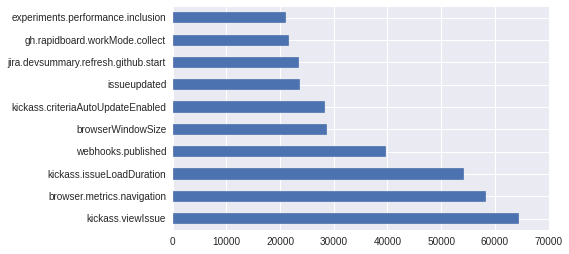

In [12]:
df.event.value_counts().head(n=10).plot(kind='barh')
plt.show()

## Cleaning

- remove product col
- label encode instance, username, event
- extract year, month, day, hour, minute, weekday from ts

In [13]:
df_clean = df.drop(['product'], axis=1)
df_clean.head()

,ts,u_ts,instance,user_name,event,extra
0,"2014-12-01 16:00:02,153",1417410002153,3998740a9e4924af7feedeb2e04190f6,d50d63ec8ecdf32d1dd9ae4a0cecd2f8,quickbrowse,{'issueKey': 'eaf34eb91618cf3e1bf487a822a2cce6'}
1,"2014-12-01 16:00:07,691",1417410007691,3998740a9e4924af7feedeb2e04190f6,d50d63ec8ecdf32d1dd9ae4a0cecd2f8,kickass.criteriaAutoUpdateEnabled,{'context_pageTime': '6ce628243b670aff9f549029...
2,"2014-12-01 16:00:07,691",1417410007691,3998740a9e4924af7feedeb2e04190f6,d50d63ec8ecdf32d1dd9ae4a0cecd2f8,kickass.viewIssue,{'context_pageSession': 'a09b1242b4712e1cb23bf...
3,"2014-12-01 16:00:07,691",1417410007691,3998740a9e4924af7feedeb2e04190f6,d50d63ec8ecdf32d1dd9ae4a0cecd2f8,browserWindowSize,"{'width': '00409424d52c3a1a30e98cd1cd91638a', ..."
4,"2014-12-01 16:00:10,523",1417410010523,c93da7e17688ef90fc43963b5a6c6259,2cc91ff23ca6213e8a7d2513a31d8fa8,lexorankbalance,{'fieldId': '4537ecbd3f85c18825157673510a445d'...


In [14]:
from sklearn.preprocessing import LabelEncoder

In [15]:
le_instance = LabelEncoder().fit(df_clean.instance)
le_username = LabelEncoder().fit(df_clean.user_name)
le_event    = LabelEncoder().fit(df_clean.event)

In [16]:
df_clean['instance'] = le_instance.transform(df_clean.instance)
df_clean['user_name'] = le_username.transform(df_clean.user_name)
df_clean['event'] = le_event.transform(df_clean.event)

df_clean.head()

,ts,u_ts,instance,user_name,event,extra
0,"2014-12-01 16:00:02,153",1417410002153,3,405,430,{'issueKey': 'eaf34eb91618cf3e1bf487a822a2cce6'}
1,"2014-12-01 16:00:07,691",1417410007691,3,405,383,{'context_pageTime': '6ce628243b670aff9f549029...
2,"2014-12-01 16:00:07,691",1417410007691,3,405,402,{'context_pageSession': 'a09b1242b4712e1cb23bf...
3,"2014-12-01 16:00:07,691",1417410007691,3,405,103,"{'width': '00409424d52c3a1a30e98cd1cd91638a', ..."
4,"2014-12-01 16:00:10,523",1417410010523,12,84,404,{'fieldId': '4537ecbd3f85c18825157673510a445d'...


In [17]:
df_clean.drop(['extra'], axis=1, inplace=True)

In [18]:
df_clean.head()

,ts,u_ts,instance,user_name,event
0,"2014-12-01 16:00:02,153",1417410002153,3,405,430
1,"2014-12-01 16:00:07,691",1417410007691,3,405,383
2,"2014-12-01 16:00:07,691",1417410007691,3,405,402
3,"2014-12-01 16:00:07,691",1417410007691,3,405,103
4,"2014-12-01 16:00:10,523",1417410010523,12,84,404


In [19]:
from datetime import datetime

In [20]:
# extract day, hour period
# data is 1 month, 1 year specific --> no longer to extract, keep everything compact
temp = pd.DatetimeIndex(df_clean.ts.apply(lambda x: x.split(',')[0]))
df_clean['day'] = temp.day
df_clean['hour'] = temp.hour
df_clean['minute'] = temp.minute
df_clean['weekday'] = temp.weekday

In [21]:
df_clean['ts_date'] = temp.date

In [22]:
df_clean.columns = ['ts', 'u_ts', 'instance', 'user_name', 'event', 'day', 'hour', 'minute', 'weekday', 'ts_date']

In [23]:
df_clean.head()

,ts,u_ts,instance,user_name,event,day,hour,minute,weekday,ts_date
0,"2014-12-01 16:00:02,153",1417410002153,3,405,430,1,16,0,0,2014-12-01
1,"2014-12-01 16:00:07,691",1417410007691,3,405,383,1,16,0,0,2014-12-01
2,"2014-12-01 16:00:07,691",1417410007691,3,405,402,1,16,0,0,2014-12-01
3,"2014-12-01 16:00:07,691",1417410007691,3,405,103,1,16,0,0,2014-12-01
4,"2014-12-01 16:00:10,523",1417410010523,12,84,404,1,16,0,0,2014-12-01


In [24]:
columns_changed = ['ts', 'ts_date', 'u_ts', 'weekday', 'day', 'hour', 'minute', 'instance', 'user_name', 'event']
df_clean2 = df_clean[columns_changed]
df_clean2.head()

,ts,ts_date,u_ts,weekday,day,hour,minute,instance,user_name,event
0,"2014-12-01 16:00:02,153",2014-12-01,1417410002153,0,1,16,0,3,405,430
1,"2014-12-01 16:00:07,691",2014-12-01,1417410007691,0,1,16,0,3,405,383
2,"2014-12-01 16:00:07,691",2014-12-01,1417410007691,0,1,16,0,3,405,402
3,"2014-12-01 16:00:07,691",2014-12-01,1417410007691,0,1,16,0,3,405,103
4,"2014-12-01 16:00:10,523",2014-12-01,1417410010523,0,1,16,0,12,84,404


In [25]:
# save to reuse later
df_clean2.to_csv("out/jira_clean_lamp2.csv")

In [26]:
df_clean2.describe()

,u_ts,weekday,day,hour,minute,instance,user_name,event
count,5.924580e+05,592458.000000,592458.000000,592458.000000,592458.000000,592458.000000,592458.000000,592458.000000
mean,1.418589e+12,2.356172,14.800642,11.700620,30.106463,10.382689,222.969925,293.831973
std,7.353617e+08,1.627109,8.469513,6.260906,17.450860,3.426601,134.710422,142.640790
min,1.417410e+12,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.418008e+12,1.000000,8.000000,6.000000,15.000000,7.000000,107.000000,142.000000
50%,1.418638e+12,2.000000,15.000000,13.000000,30.000000,12.000000,202.000000,348.000000
75%,1.419214e+12,4.000000,22.000000,17.000000,46.000000,13.000000,353.000000,393.000000
max,1.420030e+12,6.000000,31.000000,23.000000,59.000000,15.000000,486.000000,551.000000


In [27]:
df_clean2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 592458 entries, 0 to 592457
Data columns (total 10 columns):
ts           592458 non-null object
ts_date      592458 non-null object
u_ts         592458 non-null int64
weekday      592458 non-null int32
day          592458 non-null int32
hour         592458 non-null int32
minute       592458 non-null int32
instance     592458 non-null int64
user_name    592458 non-null int64
event        592458 non-null int64
dtypes: int32(4), int64(4), object(2)
memory usage: 40.7+ MB


## Export

In [28]:
from sklearn.externals import joblib

In [29]:
joblib.dump(le_event, "out/le_event.pkl")
joblib.dump(le_username, "out/le_username.pkl")
joblib.dump(le_instance, "out/le_instance.pkl")

['out/le_instance.pkl', 'out/le_instance.pkl_01.npy']

# Part 1: EDA

## Load clean

In [ ]:
df_clean2 = pd.read_csv('./jira_clean_lamp.csv')
columns = ['ts', 'ts_date', 'u_ts', 'weekday', 'day', 'hour', 'minute', 'instance', 'user_name', 'event']
df_clean2 = df_clean2[columns]
df_clean2.head()

In [ ]:
df_clean2.info()

In [ ]:
df_clean2.describe()

## Distribution Viz

- Events by user/instance/type are followed Long tail distribution

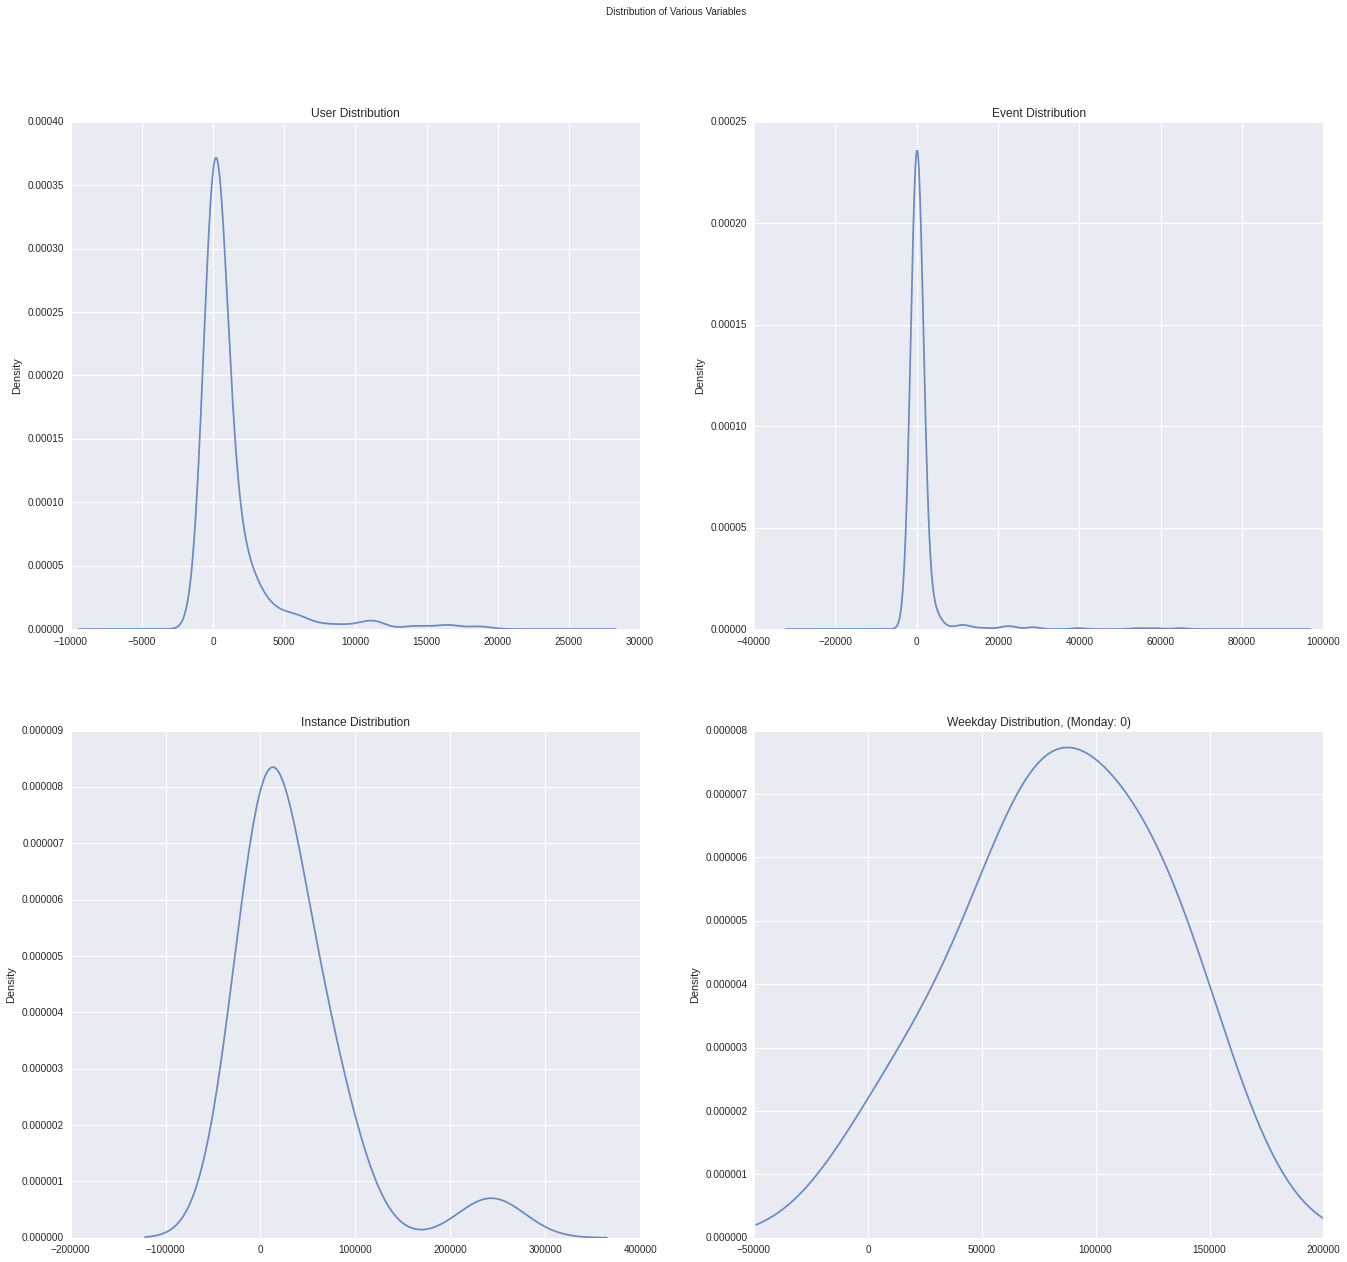

In [40]:
fix, ax = plt.subplots(figsize=(20, 20))
plt.suptitle('Distribution of Various Variables')

plt.subplot(2, 2, 1) 
plt.title("User Distribution")
df_clean2.user_name.value_counts().plot(kind='kde', alpha=0.8)

plt.subplot(2, 2, 2) 
plt.title("Event Distribution")
df_clean2.event.value_counts().plot(kind='kde', alpha=0.8)

plt.subplot(2, 2, 3) 
plt.title("Instance Distribution")
df_clean2.instance.value_counts().plot(kind='kde', alpha=0.8)

plt.subplot(2, 2, 4) 
plt.title("Weekday Distribution, (Monday: 0)")
df_clean2.weekday.value_counts().plot(kind='kde', alpha=0.8)

plt.show()

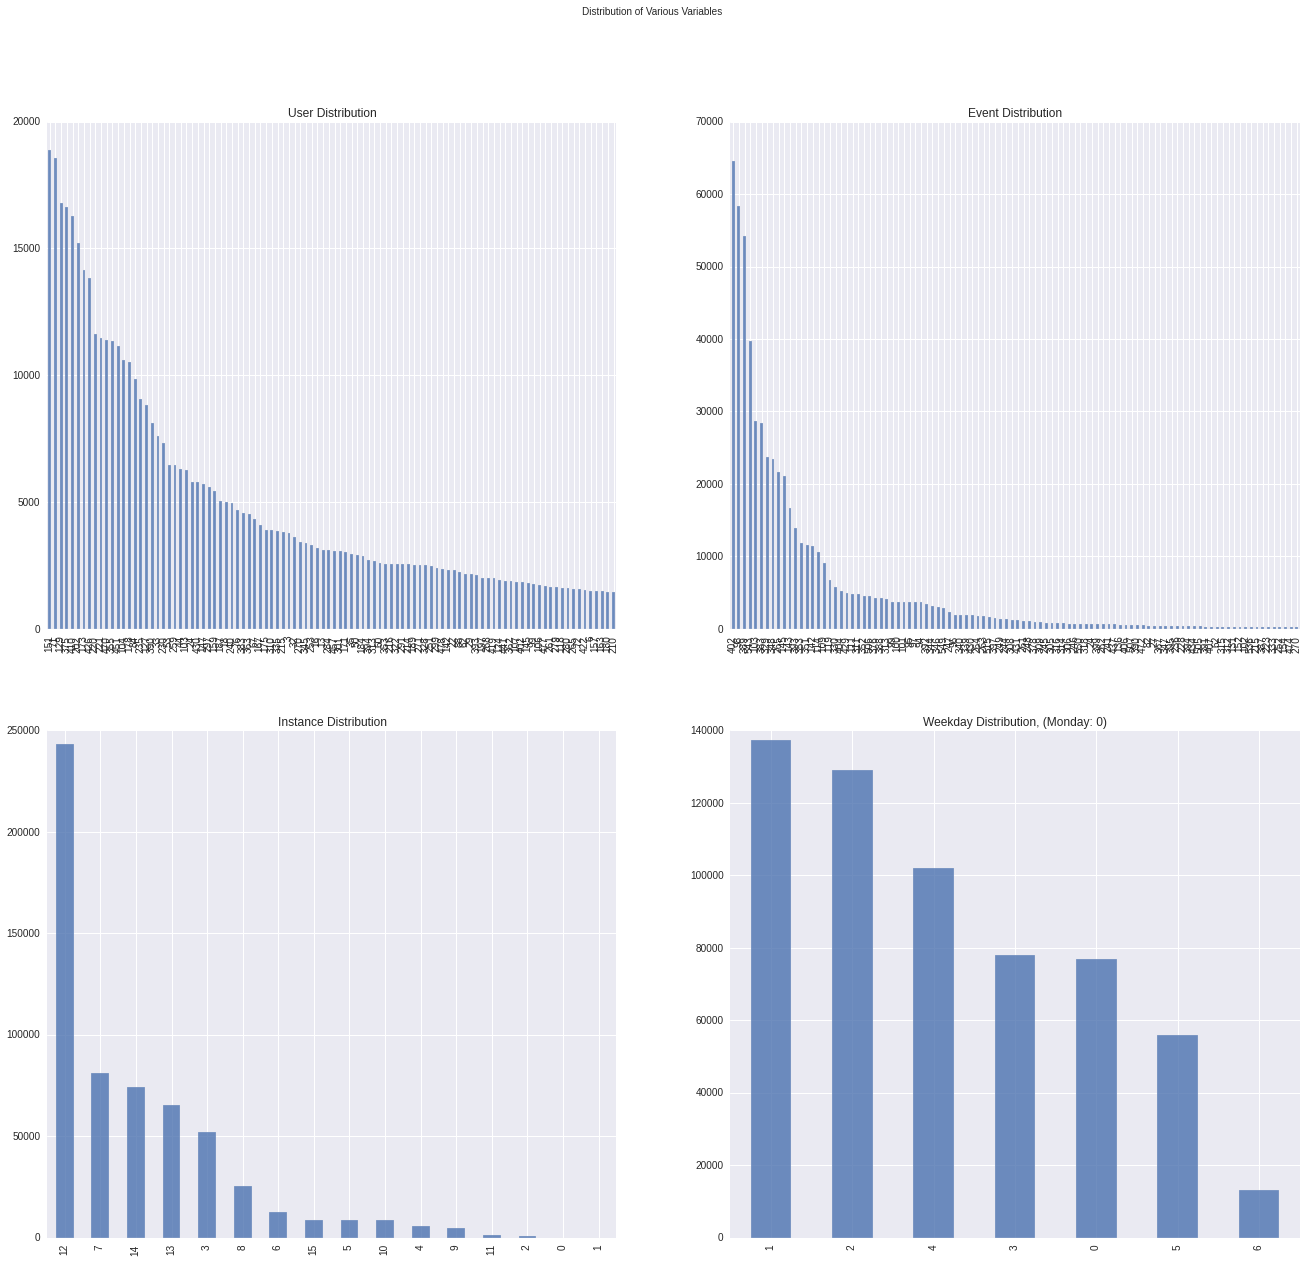

In [41]:
fix, ax = plt.subplots(figsize=(20, 20))
plt.suptitle('Distribution of Various Variables')

plt.subplot(2, 2, 1) 
plt.title("User Distribution")
df_clean2.user_name.value_counts().head(100).plot(kind='bar', alpha=0.8)

plt.subplot(2, 2, 2) 
plt.title("Event Distribution")
df_clean2.event.value_counts().head(100).plot(kind='bar', alpha=0.8)

plt.subplot(2, 2, 3) 
plt.title("Instance Distribution")
df_clean2.instance.value_counts().plot(kind='bar', alpha=0.8)

plt.subplot(2, 2, 4) 
plt.title("Weekday Distribution, (Monday: 0)")
df_clean2.weekday.value_counts().plot(kind='bar', alpha=0.8)

plt.show()

** NOTE **

- In genereal, the distributions are quite skew, imbalance.
- Event 402: viewIssue dominates the distribution
- Instance 12 dominated this distribution
- More event on Tue and go forth, less at weekend 

## Time analysis

- Global view: DAU, DAI, DAE

In [42]:
day_grouped = df_clean2.groupby('day')
dag = day_grouped.agg({
                        'user_name': pd.Series.nunique,
                        'instance': pd.Series.nunique,
                        'event': pd.Series.nunique
                      })

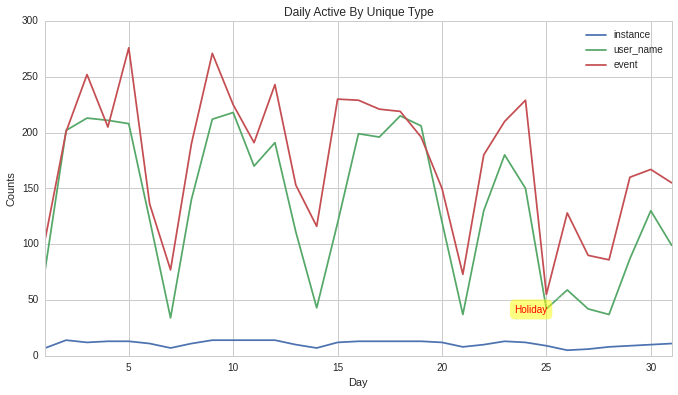

In [43]:
with sns.axes_style("whitegrid"):
    dag.plot(figsize=(10,6))
    plt.xlabel("Day")
    plt.ylabel("Counts")
    plt.title("Daily Active By Unique Type")
    plt.annotate('Holiday', (dag.index[25], dag.event[25]), xycoords='data',
                xytext = (-20, -20), textcoords = 'offset points', ha = 'right', va = 'bottom', 
                bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
                arrowprops = dict(arrowstyle = '->', facecolor = 'black' , connectionstyle = 'arc3,rad=0'),
                fontsize=10, color='r'
            )
    plt.legend()

NOTE: We can see cycles of data, e.g. special holiday like Chrismas Eve around 24-25

## Event based

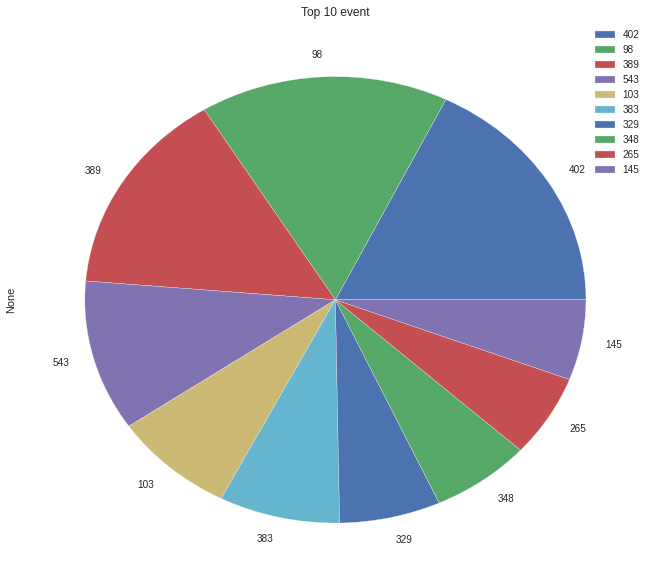

In [44]:
df_clean2.event.value_counts().head(10).plot(kind='pie', figsize=(10,10))
plt.title("Top 10 event")
plt.legend()
plt.show()

In [45]:
dae = day_grouped.agg({
                        'event': pd.Series.count
                      })

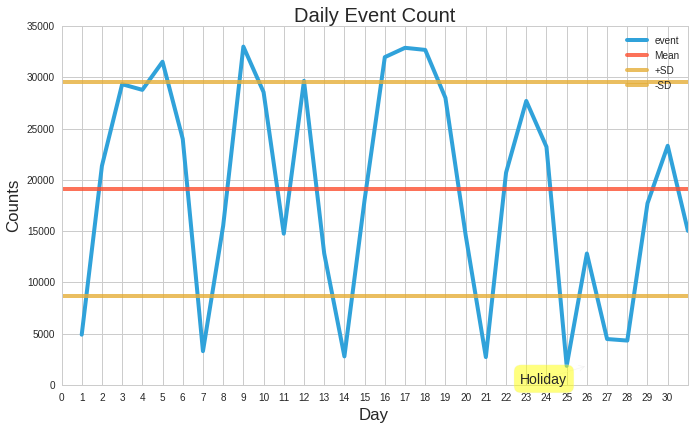

In [46]:
plt.style.use('fivethirtyeight')
mean_event_per_day = np.mean(dae.event)
up_1sd_event_per_day = mean_event_per_day + np.std(dae.event)
low_1sd_event_per_day = mean_event_per_day - np.std(dae.event)

with sns.axes_style("whitegrid"):
    dae.plot(figsize=(10,6))
    plt.axhline(mean_event_per_day, 0, 1.0, color='#fc4f30', alpha=0.8, label='Mean')
    plt.axhline(up_1sd_event_per_day, 0, 1.0, color='#e5ae38', alpha=0.8, label='+SD')
    plt.axhline(low_1sd_event_per_day, 0, 1.0, color='#e5ae38', alpha=0.8, label='-SD')
    plt.xticks(np.arange(31))
    plt.xlabel("Day")
    plt.ylabel("Counts")
    plt.title("Daily Event Count")
    plt.annotate('Holiday', (dae.index[25], dae.event[25]), xycoords='data',
                xytext = (-20, -20), textcoords = 'offset points', ha = 'right', va = 'bottom', 
                bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
                arrowprops = dict(arrowstyle = '->', facecolor = 'black' , connectionstyle = 'arc3,rad=0'),
            )
#     plt.yscale('log')
    plt.legend()

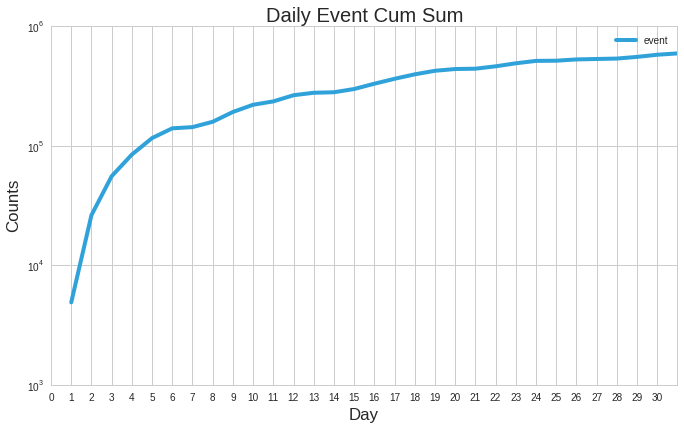

In [47]:
plt.clf()

with sns.axes_style("whitegrid"):
    dae.cumsum().plot(figsize=(10,6))
    plt.xticks(np.arange(31))
    plt.xlabel("Day")
    plt.ylabel("Counts")
    plt.title("Daily Event Cum Sum")
    plt.yscale('log')
    plt.legend()

> From 24th so forth, number of events cannot keep traction

## Trend estimator using Hodrick Prescott

In [48]:
import statsmodels.api as sm

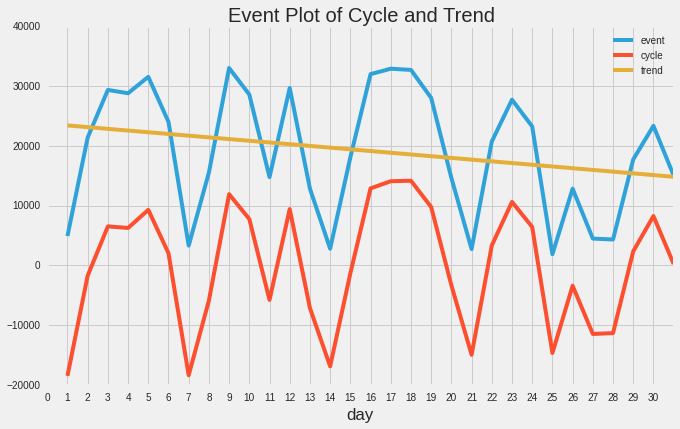

In [49]:
event_cycle, event_trend = sm.tsa.filters.hpfilter(dae.event, lamb=1e6)
dae['cycle'] = event_cycle
dae['trend'] = event_trend

dae.plot(figsize=(10,6), title='Event Plot of Cycle and Trend')
plt.xticks(np.arange(31))
plt.show()

NOTE: In this plot, it is clear to see the trend moving down by the end of year. The cycle replicates the actual subtle changes.

## Day Hour group

In [50]:
day_hour_grouped = df_clean2.groupby(['day', 'hour'])
dhc = day_hour_grouped.agg({
                        'event': pd.Series.count
                      })

In [51]:
dhc.reset_index(inplace=True)

In [52]:
dhc.head()

,day,hour,event
0,1,16,260
1,1,17,982
2,1,18,1377
3,1,19,825
4,1,20,899


In [53]:
dhc_pivot = dhc.pivot('day', 'hour', 'event')
dhc_pivot.fillna(0, inplace=True)
dhc_pivot.head()

hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,260,982,1377,825,899,311,122,116
2,646,452,733,1661,913,1316,1822,1367,1091,1254,609,253,931,701,1069,745,775,1014,998,654,852,634,652,226
3,215,1183,1874,2214,494,1757,2041,1501,1351,1201,480,893,1236,1395,1572,1431,1119,818,1105,2230,1398,1382,292,159
4,501,564,1543,1554,4376,964,1098,1872,2143,615,874,423,1433,1019,1403,1266,952,998,1135,1303,1569,765,241,179
5,294,1281,890,1680,1420,1308,2410,1240,1507,1615,1529,1094,704,1508,1676,1316,713,1853,1710,1197,1570,1704,1029,288


/home/laampt/ds/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


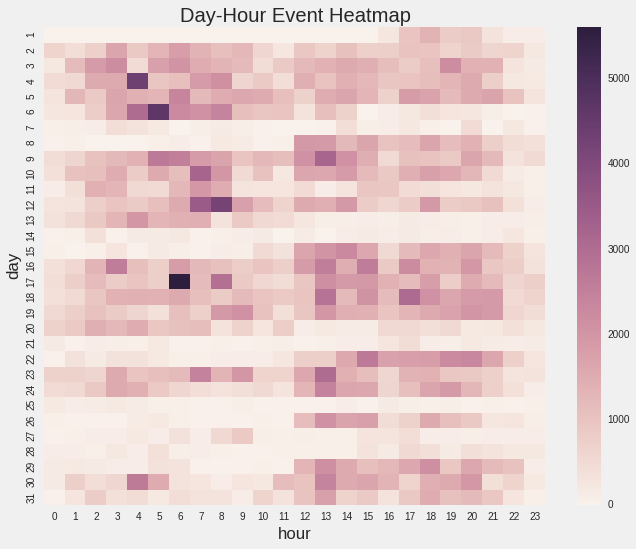

In [54]:
fig = plt.figure(figsize=(10,8), dpi=1600)
ax = fig.add_subplot(111)
ax = sns.heatmap(dhc_pivot)
plt.title("Day-Hour Event Heatmap")
plt.legend()
plt.show()

NOTE:

> There are some peaks at 4 AM of 4th, 5 AM of 6th and 6 AM of 17th.
> On 21st, 25th holidays take place and keep continuing by year end season.

## Day - Event type

In [55]:
event_top10 = list(df_clean2.event.value_counts().head(10).index)
print event_top10

[402, 98, 389, 543, 103, 383, 329, 348, 265, 145]


In [56]:
day_event_grouped = df_clean2.groupby(['day', 'event'])
dec = day_event_grouped.agg({
                                'user_name': pd.Series.count
                            })

In [57]:
dec.reset_index(inplace=True)
dec.head()

,day,event,user_name
0,1,24,1
1,1,77,1
2,1,82,3
3,1,83,1
4,1,84,1


In [58]:
top10_event_mask = dec.event.isin(event_top10)
dec_top10 = dec[top10_event_mask]
dec_top10.tail()

,day,event,user_name
5350,31,348,829
5365,31,383,690
5369,31,389,987
5382,31,402,1470
5416,31,543,1041


In [59]:
dec_top10_pivot = dec_top10.pivot('day', 'event', 'user_name')
dec_top10_pivot.fillna(0, inplace=True)
dec_top10_pivot.head()

event,98,103,145,265,329,348,383,389,402,543
day,,,,,,,,,,
1,456,333,0,51,148,0,312,404,590,447
2,2207,1276,0,597,807,0,1275,1872,2552,1119
3,3297,1726,0,706,630,0,1764,3243,3971,1595
4,2872,1255,0,637,2492,581,1271,3388,3649,2870
5,3033,1609,0,671,608,1314,1619,3149,3867,1992


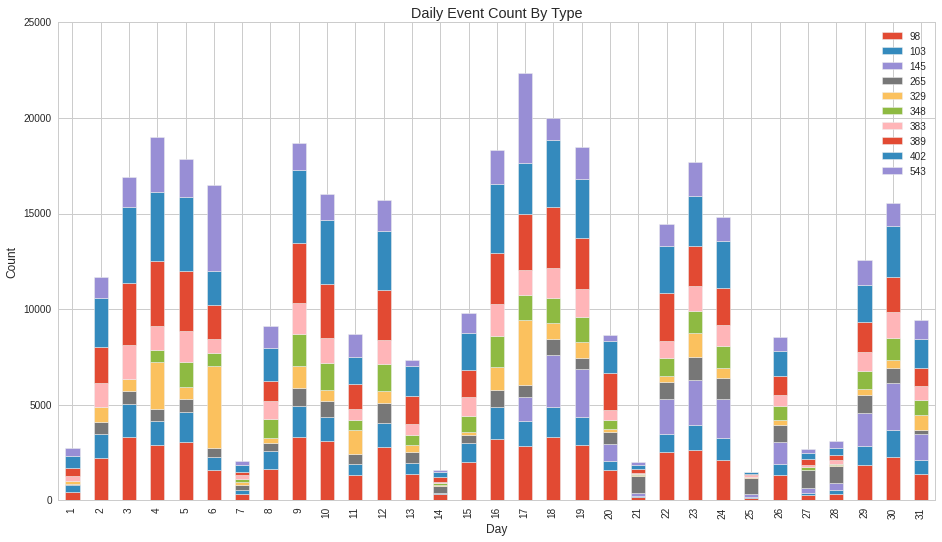

In [60]:
plt.style.use('ggplot')
with sns.axes_style("whitegrid"):
    dec_top10_pivot.plot(kind='bar', stacked=True, figsize=(14,8))
    plt.xlabel("Day")
    plt.ylabel("Count")
    plt.title("Daily Event Count By Type")
    plt.legend()

In [61]:
for i in event_top10:
    print "Event {}: {}".format(i, le_event.inverse_transform(i))

Event 402: kickass.viewIssue
Event 98: browser.metrics.navigation
Event 389: kickass.issueLoadDuration
Event 543: webhooks.published
Event 103: browserWindowSize
Event 383: kickass.criteriaAutoUpdateEnabled
Event 329: issueupdated
Event 348: jira.devsummary.refresh.github.start
Event 265: gh.rapidboard.workMode.collect
Event 145: experiments.performance.inclusion


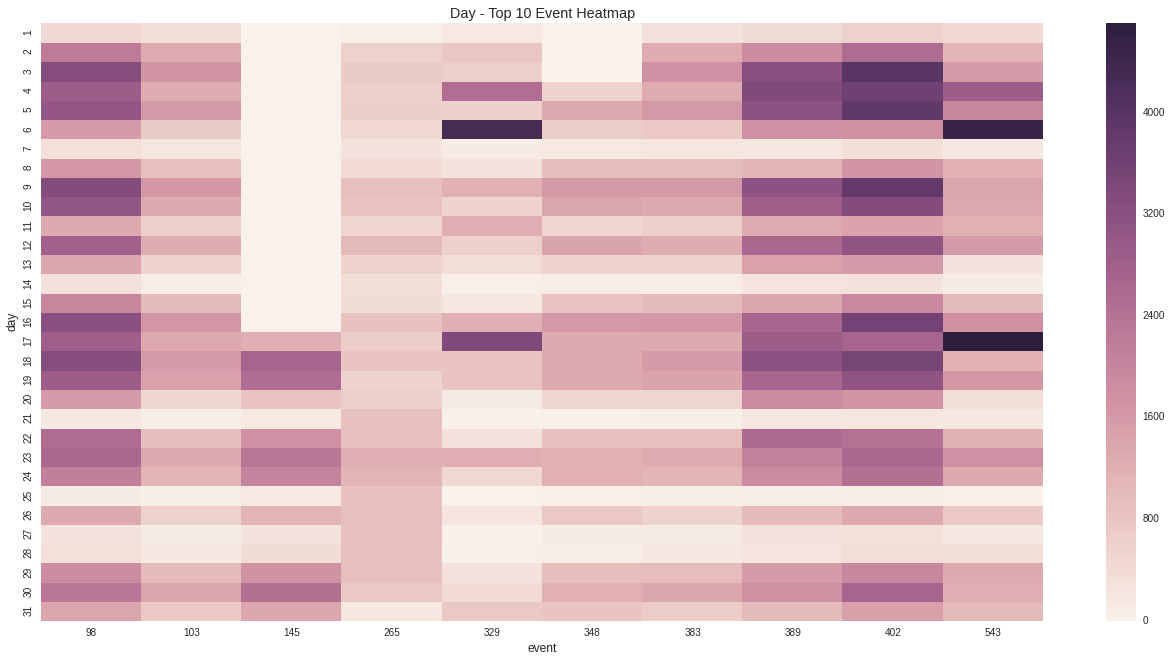

In [62]:
plt.style.use('ggplot')
with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(20,10), dpi=400)
    ax = fig.add_subplot(111)
    ax = sns.heatmap(dec_top10_pivot)
    plt.title("Day - Top 10 Event Heatmap")
    plt.legend()
    plt.show()

NOTE: event 402 - viewIssue appear to very active along the days

In [63]:
dec_pivot = dec.pivot('day', 'event', 'user_name')
dec_pivot.fillna(0, inplace=True)
dec_pivot.head()

event,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3,1,1,0,0,0,0,0,0,0,0,0,53,53,42,53,456,53,53,53,4,333,0,0,0,0,0,126,0,70,0,0,126,0,0,0,0,111,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,5,1,0,0,0,0,104,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,6,0,0,7,16,0,15,3,12,0,0,0,9,0,0,0,0,0,0,0,3,6,3,3,51,0,0,0,2,3,0,0,0,0,0,0,0,0,0,4,4,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,17,15,0,8,2,0,57,4,32,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,148,53,0,0,2,0,0,0,0,0,7,7,0,0,0,0,0,0,0,0,0,0,98,35,102,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,18,0,3,0,0,0,0,312,0,0,0,4,33,404,2,3,36,68,3,0,0,4,0,5,0,0,590,0,73,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,19,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,1,3,0,0,0,0,0,0,0,1,0,0,0,0,7,0,1,0,0,0,0,0,0,0,0,0,0,6,121,23,0,0,0,0,0,0,0,36,0,0,1,1,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,447,0,0,0,0,0,74,11,0
2,1,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,3,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,9,1,1,0,0,

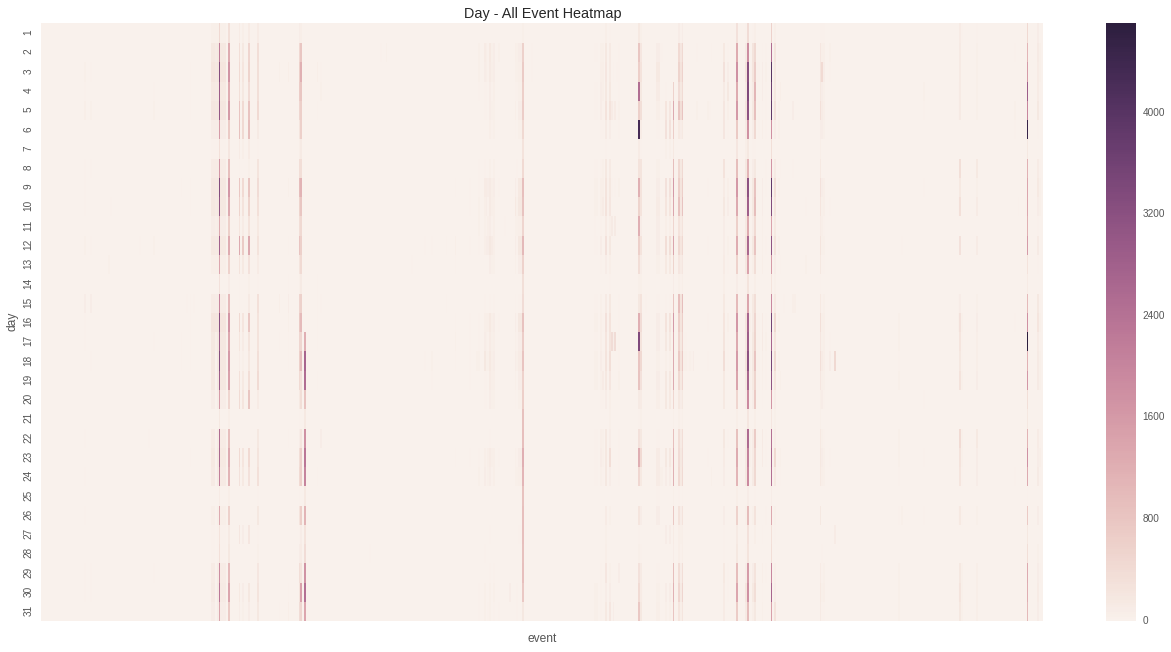

In [64]:
fig = plt.figure(figsize=(20,10), dpi=400)
ax = fig.add_subplot(111)
ax = sns.heatmap(dec_pivot, xticklabels=False)
plt.title("Day - All Event Heatmap")
plt.legend()
plt.show()

NOTE: From global point of views, the event type - day matrix is sparse in this barcode plot

## Correlation

- Instance: num of users vs num of events

In [65]:
instance_grouped = df_clean2.groupby(['instance'])

iue = instance_grouped.agg({
                        'user_name': pd.Series.nunique,
                        'event': pd.Series.nunique,
                        'u_ts': pd.Series.count
                      })

In [66]:
iue = iue[['user_name', 'event', 'u_ts']]
iue.columns = ['uniq_user', 'uniq_event', 'total_event']
iue.reset_index(inplace=True)
iue.head()

,instance,uniq_user,uniq_event,total_event
0,0,1,13,16
1,1,1,4,4
2,2,7,36,747
3,3,59,202,52240
4,4,5,71,5703


In [67]:
from sklearn.preprocessing import MinMaxScaler

In [70]:
uniq_user_scaler = MinMaxScaler().fit(iue.uniq_user.values.astype(float))
iue['uniq_user_scaled'] = uniq_user_scaler.transform(iue.uniq_user.values.astype(float))
iue.head()

,instance,uniq_user,uniq_event,total_event,uniq_user_scaled
0,0,1,13,16,0.000000
1,1,1,4,4,0.000000
2,2,7,36,747,0.038462
3,3,59,202,52240,0.371795
4,4,5,71,5703,0.025641


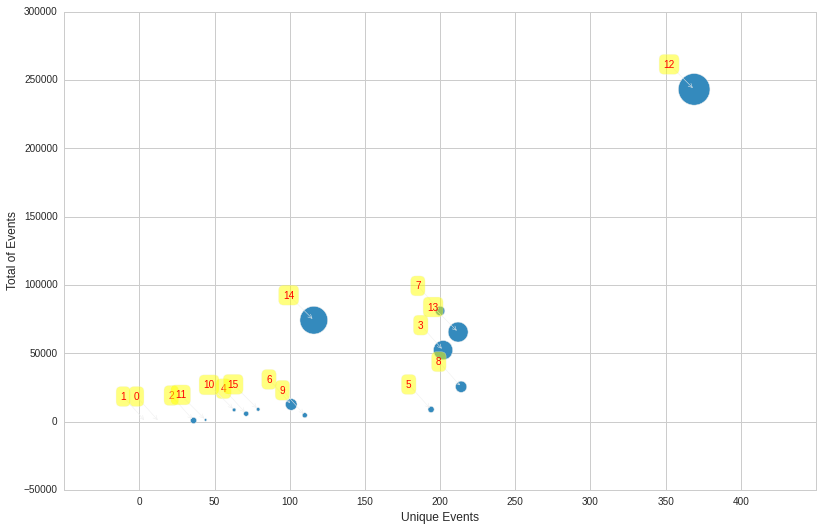

In [71]:
with sns.axes_style("whitegrid"):
    iue.plot(kind='scatter', x='uniq_event', y='total_event', s=iue.uniq_user_scaled * 1000, figsize=(12,8))
    plt.xlabel("Unique Events")
    plt.ylabel("Total of Events")
    plt.xlim((-50,450))
    plt.xticks(np.arange(0,450,50))
    for i in range(iue.instance.size):
        plt.annotate(str(iue.instance[i]), (iue.uniq_event[i], iue.total_event[i]), xycoords='data',
#                 xytext=(iue.uniq_event[i], iue.total_event[i]), textcoords='data',
                xytext = (-20, 20), textcoords = 'offset points', ha = 'right', va = 'bottom', 
                bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
                arrowprops = dict(arrowstyle = '->', facecolor = 'black' , connectionstyle = 'arc3,rad=0'),
                fontsize=10, color='r'
                )
    plt.legend()
    plt.show()

In [73]:
joblib.dump(uniq_user_scaler, "out/uniq_user_scaler.pkl")

['out/uniq_user_scaler.pkl']

## Part 2 - Cluster analysis

How to group users, events based on occurrences of their clicks?

In [74]:
event_top10 = list(df_clean2.event.value_counts().head(10).index)
print event_top10

user_top10 = list(df_clean2.user_name.value_counts().head(10).index)
print user_top10

[402, 98, 389, 543, 103, 383, 329, 348, 265, 145]
[151, 71, 129, 375, 410, 202, 173, 426, 220, 221]


## User - Event Occurrences

In [75]:
user_event_grouped = df_clean2.groupby(['user_name', 'event'])
ue = user_event_grouped.agg({
                        'u_ts': pd.Series.count
                      })

ue.rename(columns={'u_ts': 'occurrences'}, inplace=True)
ue.head()

occurrences
user_name event             
0         313              1
          404              1
          543              1
1         94              12
          95              12

In [76]:
ue.reset_index(inplace=True)
ue_pivot = ue.pivot('user_name', 'event', 'occurrences')
ue_pivot.fillna(0, inplace=True)
ue_pivot.head()

event,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551
user_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,12,8,12,77,12,12,12,2,72,0,0,0,1,0,

## Similarity matrix

In [77]:
user_mat = np.asfarray(ue_pivot.as_matrix())
user_target = ue_pivot.index.values

event_mat = user_mat.T
event_target = ue_pivot.columns.values

In [80]:
from sklearn.metrics.pairwise import cosine_similarity

In [81]:
user_cosine_sim = cosine_similarity(user_mat)
event_cosine_sim = cosine_similarity(user_mat.T)

print "OCCURRENCE MAT: User {}, Event {}".format(user_mat.shape, event_mat.shape)
print "SIM MAT: User {}, Event {}".format(user_cosine_sim.shape, event_cosine_sim.shape)

OCCURRENCE MAT: User (487, 552), Event (552, 487)
SIM MAT: User (487, 487), Event (552, 552)


In [82]:
user_cosine_dissim = 1 - user_cosine_sim
event_cosine_dissim = 1 - event_cosine_sim
print "DISTANCE MAT: User {}, Event {}".format(user_cosine_dissim.shape, event_cosine_dissim.shape)

DISTANCE MAT: User (487, 487), Event (552, 552)


In [85]:
event_colors = ['r' if e in event_top10 else 'g' for e in event_target]
user_colors = ['r' if e in user_top10 else 'b' for e in event_target]

## TSNE

In [96]:
from tsne import tsne
import os
import sys

In [97]:
def tsne_viz(
        mat=None,
        rownames=None,
        indices=None,
        colors=None,
        default_color='g',
        output_filename=None,
        figheight=40,
        figwidth=50,
        display_progress=False): 
    """2d plot of mat using tsne, with the points labeled by rownames, 
    aligned with colors (defaults to all black).
    If indices is a list of indices into mat and rownames, 
    then it determines a subspace of mat and rownames to display.
    Give output_filename a string argument to save the image to disk.
    figheight and figwidth set the figure dimensions.
    display_progress=True shows the information that the tsne method prints out."""
    if not colors:
        colors = [default_color for i in range(len(rownames))]
    temp = sys.stdout
    if not display_progress:
        # Redirect stdout so that tsne doesn't fill the screen with its iteration info:
        f = open(os.devnull, 'w')
        sys.stdout = f
    tsnemat = tsne(mat)
    sys.stdout = temp
    # Plot coordinates:
    if not indices:
        indices = range(len(rownames))        
    vocab = np.array(rownames)[indices]
    xvals = tsnemat[indices, 0] 
    yvals = tsnemat[indices, 1]
    # Plotting:
    fig, ax = plt.subplots(nrows=1, ncols=1)
    fig.set_figheight(20)
    fig.set_figwidth(25)
    ax.plot(xvals, yvals, marker='', linestyle='')
    # Text labels:
    for word, x, y, color in zip(vocab, xvals, yvals, colors):
        ax.annotate(word, (x, y), fontsize=10, color=color)
    # Output:
    if output_filename:
        plt.savefig(output_filename, bbox_inches='tight')
    else:
        plt.show()

### User cluster

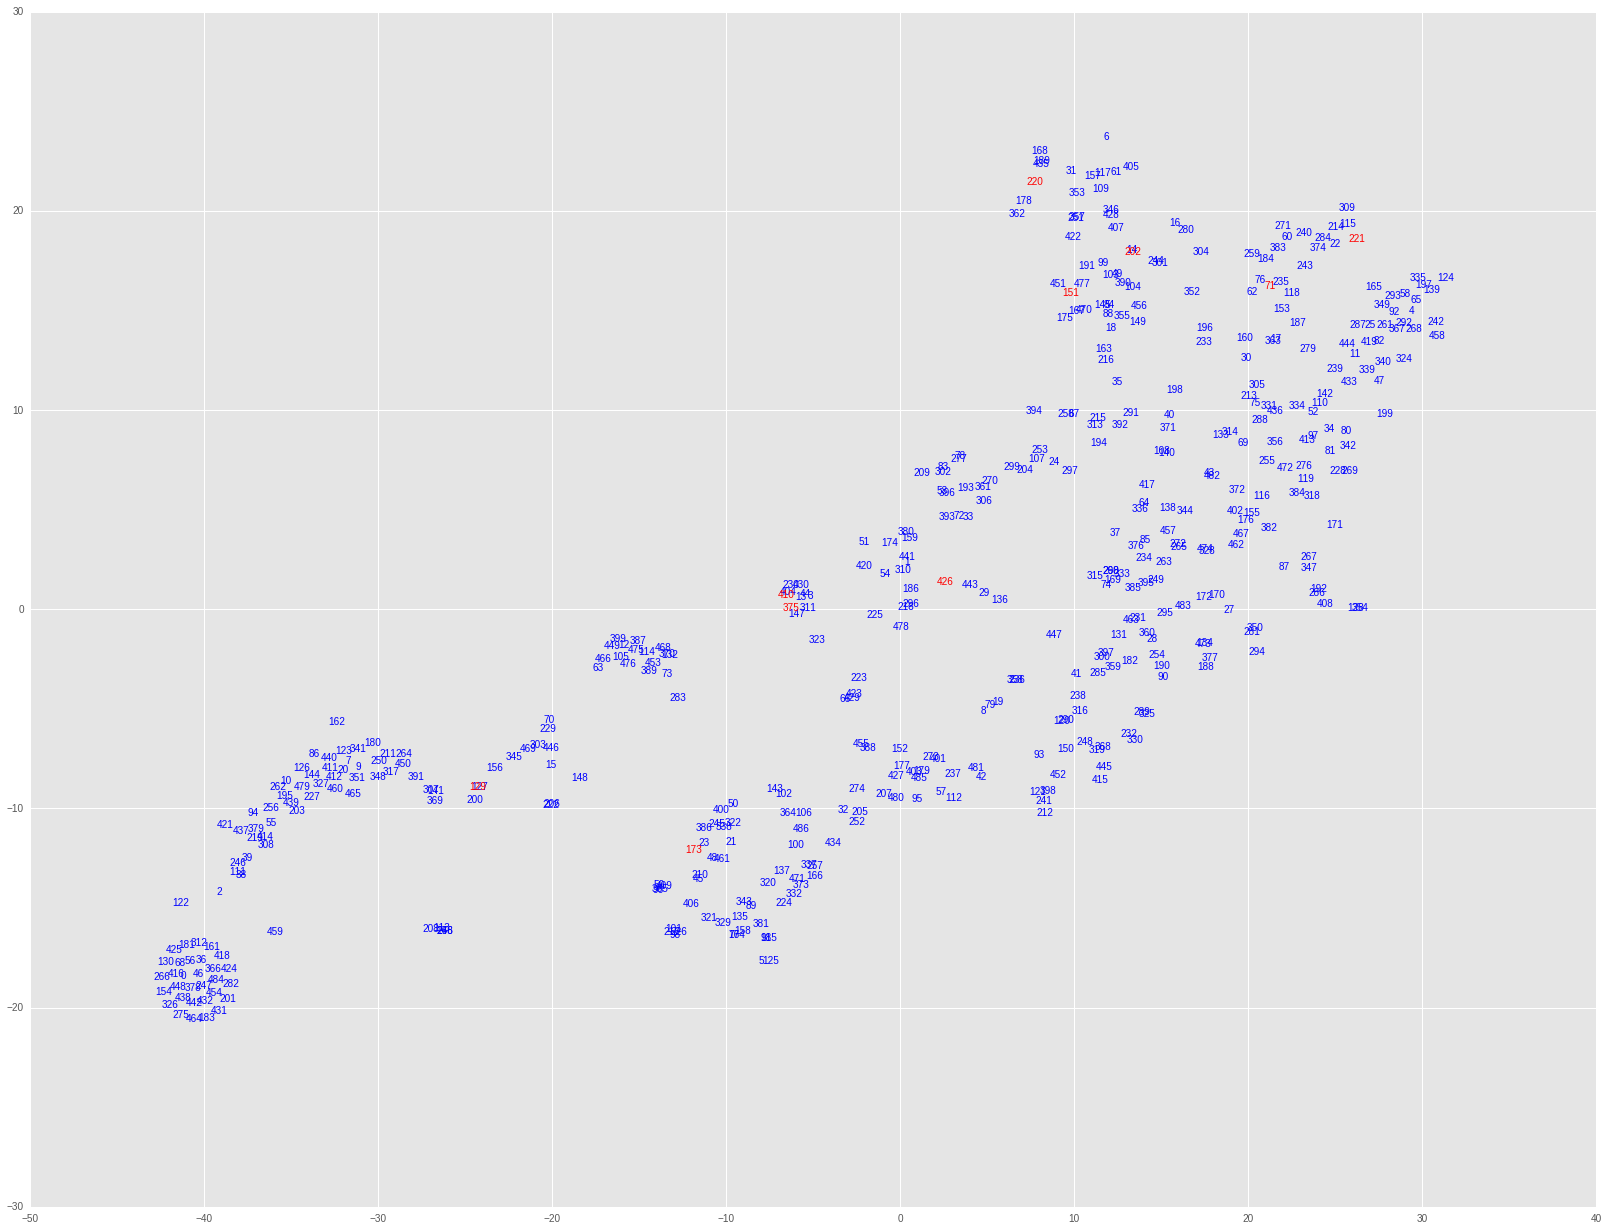

In [98]:
tsne_viz(mat=user_cosine_dissim, rownames=user_target, colors=user_colors, figwidth=25, figheight=20, display_progress=False)

### Event cluster

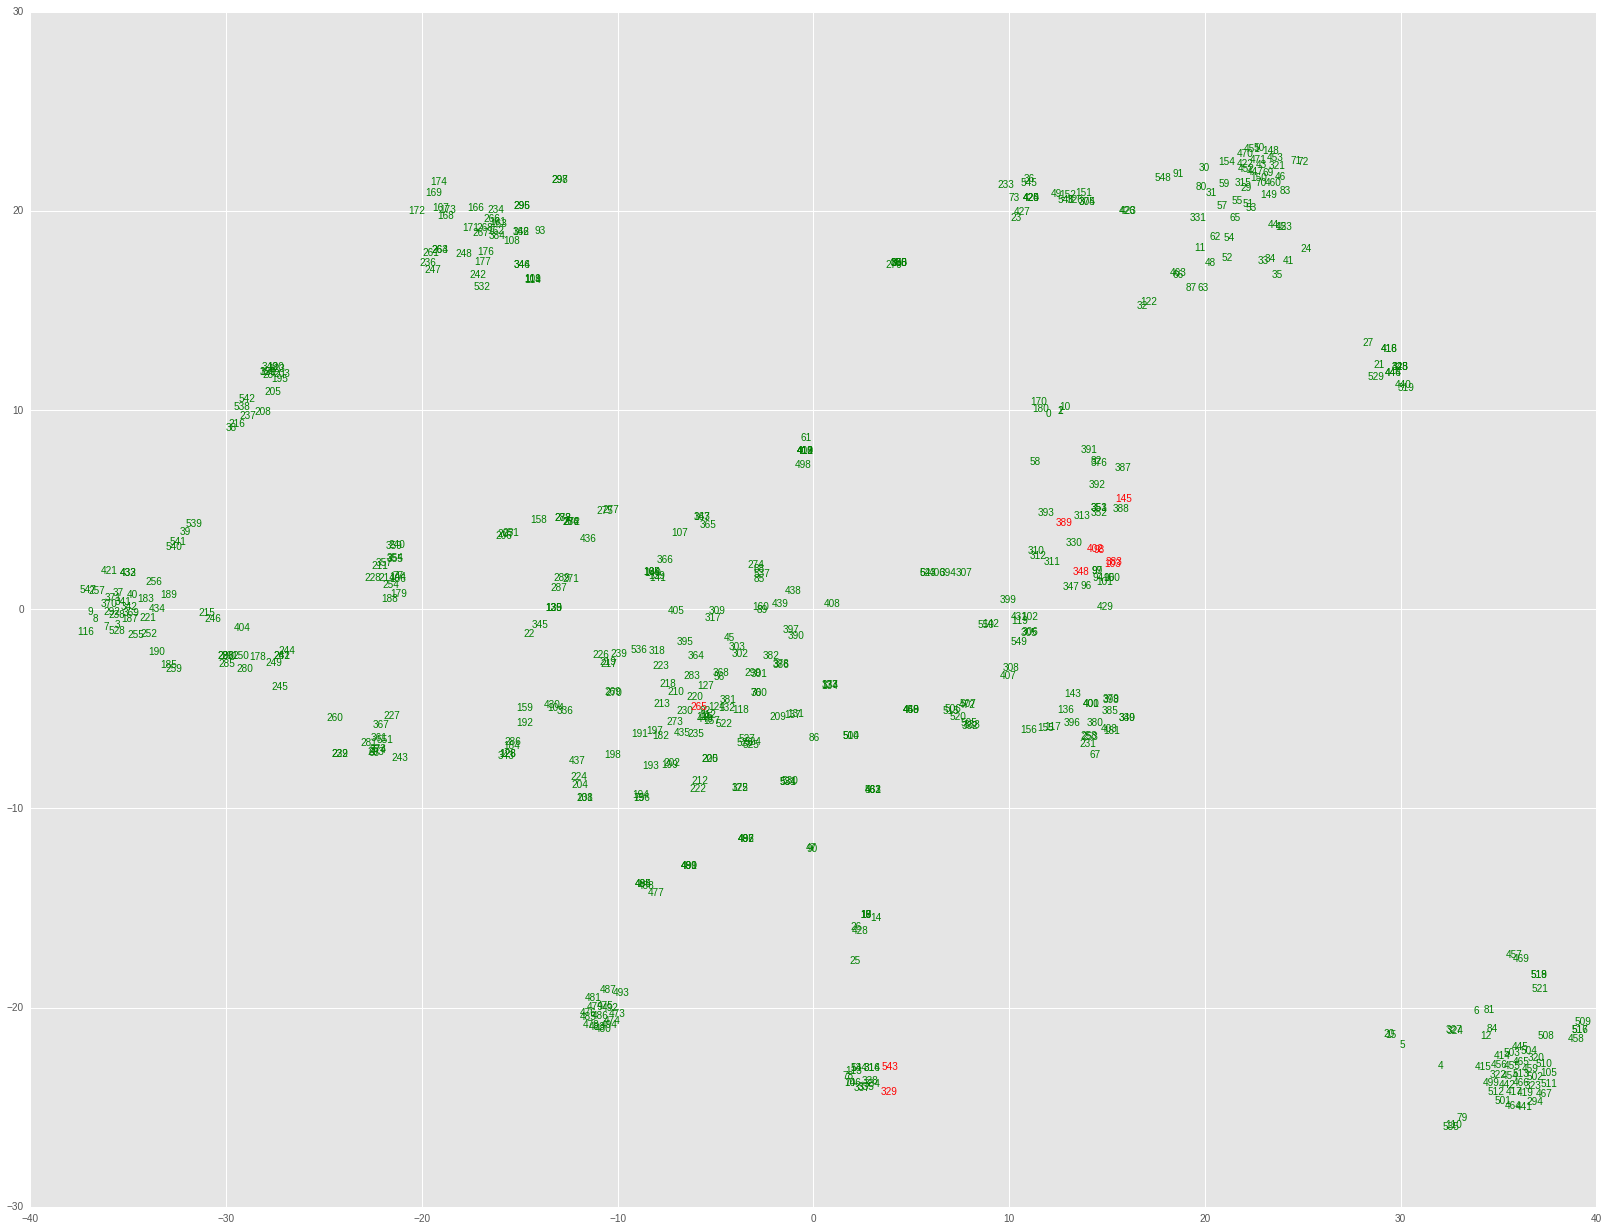

In [99]:
tsne_viz(mat=event_cosine_dissim, rownames=event_target, colors=event_colors, figwidth=25, figheight=20, display_progress=False)

## Part 3 - Cohort analysis

Stickiness - the loyalty of customers

In [118]:
df = pd.read_csv('out/jira_clean_lamp2.csv')
df.head()

,Unnamed: 0,ts,ts_date,u_ts,weekday,day,hour,minute,instance,user_name,event
0,0,"2014-12-01 16:00:02,153",2014-12-01,1417410002153,0,1,16,0,3,405,430
1,1,"2014-12-01 16:00:07,691",2014-12-01,1417410007691,0,1,16,0,3,405,383
2,2,"2014-12-01 16:00:07,691",2014-12-01,1417410007691,0,1,16,0,3,405,402
3,3,"2014-12-01 16:00:07,691",2014-12-01,1417410007691,0,1,16,0,3,405,103
4,4,"2014-12-01 16:00:10,523",2014-12-01,1417410010523,0,1,16,0,12,84,404


In [119]:
columns = ['ts', 'ts_date', 'u_ts', 'weekday', 'day', 'hour', 'minute', 'instance', 'user_name', 'event']
df = df[columns]
df.head()

,ts,ts_date,u_ts,weekday,day,hour,minute,instance,user_name,event
0,"2014-12-01 16:00:02,153",2014-12-01,1417410002153,0,1,16,0,3,405,430
1,"2014-12-01 16:00:07,691",2014-12-01,1417410007691,0,1,16,0,3,405,383
2,"2014-12-01 16:00:07,691",2014-12-01,1417410007691,0,1,16,0,3,405,402
3,"2014-12-01 16:00:07,691",2014-12-01,1417410007691,0,1,16,0,3,405,103
4,"2014-12-01 16:00:10,523",2014-12-01,1417410010523,0,1,16,0,12,84,404


In [120]:
df.dtypes

ts           object
ts_date      object
u_ts          int64
weekday       int64
day           int64
hour          int64
minute        int64
instance      int64
user_name     int64
event         int64
dtype: object

### Determine cohort group based on 1st day creating event

Assumption based on given data in 1 month

In [121]:
df.set_index('user_name', inplace=True)

df['cohort_group'] = df.groupby(level=0)['ts_date'].min()
df.reset_index(inplace=True)
df.head()

,user_name,ts,ts_date,u_ts,weekday,day,hour,minute,instance,event,cohort_group
0,405,"2014-12-01 16:00:02,153",2014-12-01,1417410002153,0,1,16,0,3,430,2014-12-01
1,405,"2014-12-01 16:00:07,691",2014-12-01,1417410007691,0,1,16,0,3,383,2014-12-01
2,405,"2014-12-01 16:00:07,691",2014-12-01,1417410007691,0,1,16,0,3,402,2014-12-01
3,405,"2014-12-01 16:00:07,691",2014-12-01,1417410007691,0,1,16,0,3,103,2014-12-01
4,84,"2014-12-01 16:00:10,523",2014-12-01,1417410010523,0,1,16,0,12,404,2014-12-01


### Roll up by cohort_group and ts_date

In [122]:
grouped = df.groupby(['cohort_group', 'ts_date'])

cohorts = grouped.agg({'user_name': pd.Series.nunique,
                       'u_ts': pd.Series.count,
                       'event': pd.Series.nunique})

# change column names
cohorts.rename(columns={'user_name': 'total_users',
                        'u_ts': 'total_records',
                        'event': 'total_events' }, inplace=True)
cohorts.head()

total_records  total_users  total_events
cohort_group ts_date                                             
2014-12-01   2014-12-01           4892           78           105
             2014-12-02           9293           68           122
             2014-12-03          13743           63           186
             2014-12-04          11012           65           135
             2014-12-05          15466           60           191

### Label each cohort

In [123]:
def cohort_period(df):
    """
    Input: dataframe
    Output: add cohort_period in daywise, so we can filter out by df[df.cohort_period == 7]
    """
    df['cohort_period'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

total_records  total_users  total_events  cohort_period
cohort_group ts_date                                                            
2014-12-01   2014-12-01           4892           78           105              1
             2014-12-02           9293           68           122              2
             2014-12-03          13743           63           186              3
             2014-12-04          11012           65           135              4
             2014-12-05          15466           60           191              5

## User retention by cohort

% total users change over time

In [124]:
# reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['cohort_group', 'ts_date'], inplace=True)

cohorts.head()

total_records  total_users  total_events  cohort_period
cohort_group ts_date                                                            
2014-12-01   2014-12-01           4892           78           105              1
             2014-12-02           9293           68           122              2
             2014-12-03          13743           63           186              3
             2014-12-04          11012           65           135              4
             2014-12-05          15466           60           191              5

In [125]:
# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['total_users'].groupby(level=0).first()
cohort_group_size.head()

cohort_group
2014-12-01     78
2014-12-02    134
2014-12-03     49
2014-12-04     29
2014-12-05     19
Name: total_users, dtype: int64

In [126]:
user_retention = cohorts['total_users'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head()

cohort_group,2014-12-01,2014-12-02,2014-12-03,2014-12-04,2014-12-05,2014-12-06,2014-12-07,2014-12-08,2014-12-09,2014-12-10,2014-12-11,2014-12-12,2014-12-13,2014-12-14,2014-12-15,2014-12-16,2014-12-17,2014-12-18,2014-12-19,2014-12-20,2014-12-22,2014-12-23,2014-12-24,2014-12-26,2014-12-29,2014-12-30,2014-12-31
ts_date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-12-01,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-02,0.871795,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-03,0.807692,0.753731,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-04,0.833333,0.671642,0.55102,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-05,0.769231,0.716418,0.44898,0.37931,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


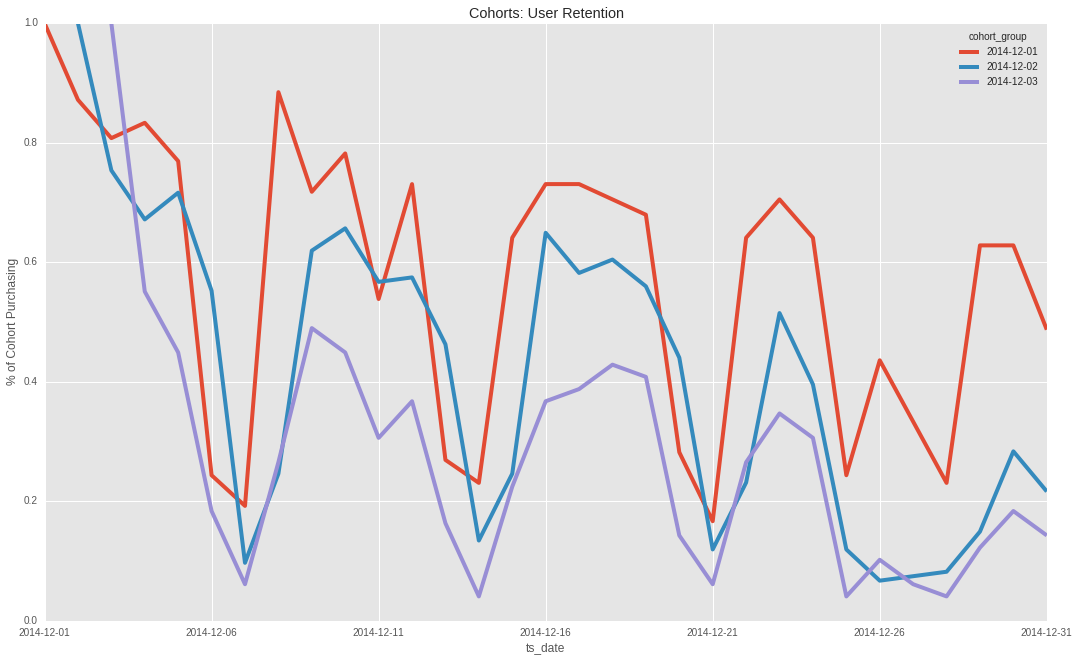

In [129]:
user_retention[['2014-12-01', '2014-12-02', '2014-12-03']].plot(figsize=(16,10))
plt.title('Cohorts: User Retention')
plt.ylabel('% of Cohort Purchasing')
plt.show()

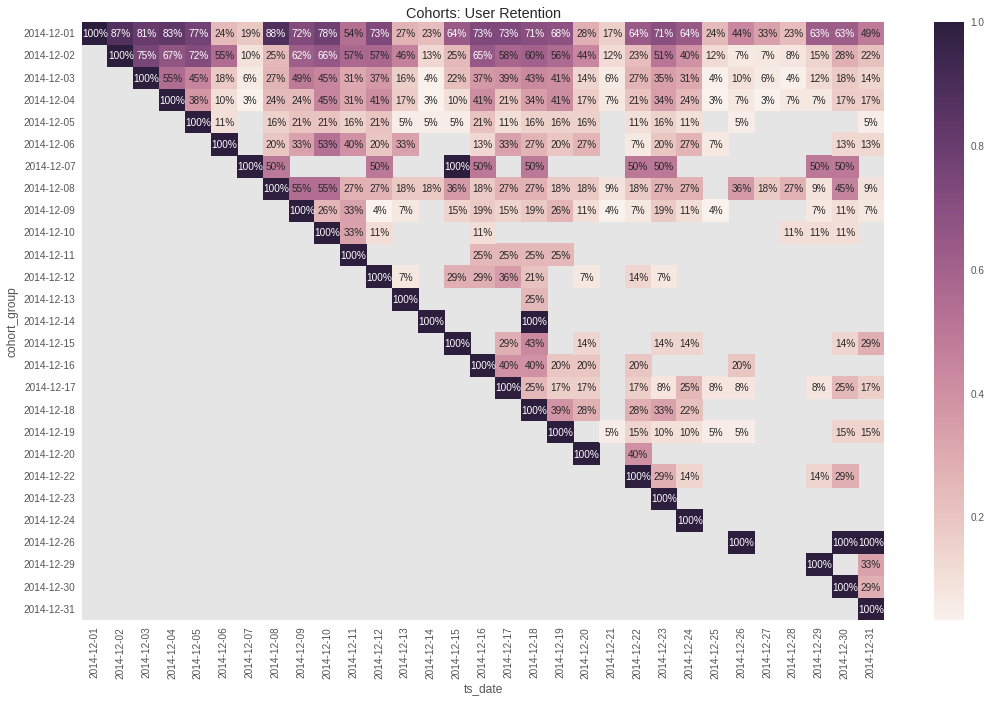

In [130]:
plt.figure(figsize=(16, 10))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%')
plt.show()

NOTE

- Cohort 12-01 is strongest, what makes differences?
- No new cohort on 21,25,27, 28 when holiday season took place

### Sanity check

In [131]:
x = df[(df.cohort_group == '2014-12-01') & (df.ts_date == '2014-12-01')]
y = cohorts.ix[('2014-12-01', '2014-12-01')]

assert(x['user_name'].nunique() == y['total_users'])
assert(x['u_ts'].count() == y['total_records'])
assert(x['event'].nunique() == y['total_events'])

## References:

Some excerpt of this report are adapted from:

- http://bugra.github.io/work/notes/2014-11-24/trend-estimation-via-hodrick-prescott-filter/
- http://karpathy.github.io/2014/08/03/quantifying-productivity/
- https://github.com/cs109/content
- http://web.stanford.edu/class/cs224u/materials/distributedwordreps.html
- http://www.gregreda.com/2015/08/23/cohort-analysis-with-python/